# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial
differential equation as a first model problem. Depending on the
interpretation of the unknowns and the type of measurements, this
model problem arises, for instance, in inversion for groundwater flow
or heat conductivity.  It can also be interpreted as finding a
membrane with a certain spatially varying stiffness. Let
$\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_\Omega (u-u_d)^2\, dx + \frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) &= f \text{ in }\Omega,\\
u &= 0 \text{ on }\partial\Omega.
\end{split}
$$

Here $m \in \mathcal{M}:=\{m\in L^{\infty}(\Omega) \bigcap H^1(\Omega)\}$ denotes the unknown coefficient field, 
$u \in \mathcal{V}:= H^1_0(\Omega)$ the state variable, $u_d$ the (possibly noisy) data, $f\in H^{-1}(\Omega)$ a given volume force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the state equation:

Find $u\in \mathcal{V}$ such that 

$$(e^m \nabla u,\nabla v) - (f,v) = 0, \text{ for all } v\in \mathcal{V},$$

where $\mathcal{V} := H_0^1(\Omega)$ is the space of functions vanishing on $\partial\Omega$ with square integrable derivatives. 

Above, $(\cdot\,\cdot)$ denotes the $L^2$-inner product, i.e, for scalar functions $u,v$ defined on $\Omega$ we write 

$$(u,v) := \int_\Omega u(x) v(x) \,dx, $$

and similarly for vector functions $\boldsymbol{u}, \boldsymbol{v}$ defined on $\Omega$ we write

$$(\boldsymbol{u},\boldsymbol{v}) := \int_\Omega \boldsymbol{u}(x) \cdot \boldsymbol{v}(x) \,dx.$$

### Gradient evaluation:

The Lagrangian functional $\mathscr{L}:\mathcal{V}\times\mathcal{M}\times\mathcal{V}\rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}(u-u_d,u-u_d) +
\frac{\gamma}{2}(\nabla m, \nabla m) +  (e^m\nabla u,\nabla p) - (f,p).
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ is

$$
    \mathcal{G}(m)(\tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +
     (\tilde{m}e^m\nabla u, \nabla p) \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in H_0^1(\Omega)$ is the solution of the forward problem,

$$ \mathscr{L}_p(u,m,p)(\tilde{p})  := (\exp(m)\nabla u, \nabla \tilde{p}) - (f,\tilde{p}) = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in H_0^1(\Omega)$ is the solution of the adjoint problem,

$$ \mathscr{L}_u(u,m,p)(\tilde{u}) := (\exp(m)\nabla p, \nabla \tilde{u}) + (u-u_d,\tilde{u}) = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Steepest descent method.

Written in abstract form, the steepest descent methods computes an update direction $\hat{m}_k$ in the direction of the negative gradient defined as 

$$
(\tilde{m}, \hat{m}_k ) = -\mathcal{G}(m_k)(\tilde m) \quad \forall \tilde{m} \in H^1(\Omega),
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involve the solution $u_k$ and $p_k$ of the forward and adjoint problem (respectively) for $m = m_k$.

Then we set $m_{k+1} = m_k + \alpha \hat{m}_k$, where the step length $\alpha$ is chosen to guarantee sufficient descent. 


### Goals:

By the end of this notebook, you should be able to:

- solve the forward and adjoint Poisson equations
- understand the inverse method framework
- visualise and understand the results
- modify the problem and code

### Mathematical tools used:

- Finite element method
- Derivation of gradient via the adjoint method
- Armijo line search

### Import dependencies

In [1]:
# Import FEniCSx
import dolfinx as dl
import ufl

from mpi4py import MPI
from petsc4py import PETSc

# Import the package of mathematical functions
import math
import numpy as np
np.random.seed(seed=1)

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('static')

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.

In this cell, we set the mesh ``mesh``, the finite element spaces ``Vm`` and ``Vu`` corresponding to the parameter space and state/adjoint space, respectively. In particular, we use linear finite elements for the parameter space, and quadratic elements for the state/adjoint space.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} \ln 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ \ln 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``f`` and the boundary conditions ``u0`` for the forward problem are

$$ f = 1 \; \forall {\bf x} \in \Omega, \quad u = 0 \; \forall {\bf x} \in \partial \Omega. $$

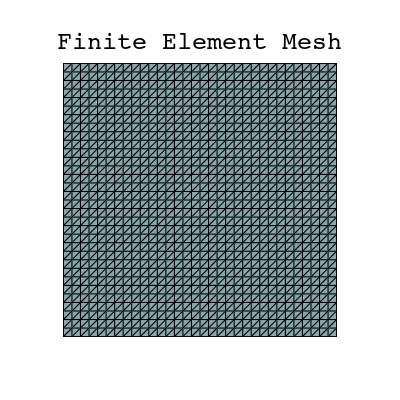

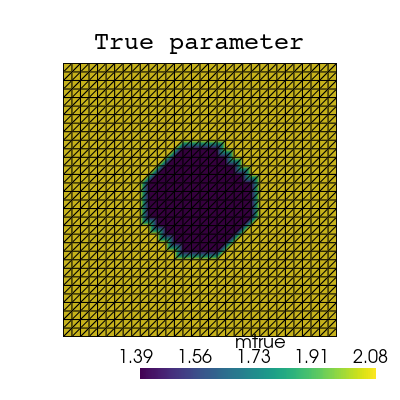

In [4]:
# create mesh and define function spaces
comm = MPI.COMM_WORLD

nx = 32
ny = 32
mesh = dl.mesh.create_unit_square(comm, nx, ny)

cells, types, coords = dl.plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pv.UnstructuredGrid(cells, types, coords)

# Create plotter
window_size=[400,400]
plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.add_title('Finite Element Mesh', font='courier', color='k',
                   font_size=10)
plotter.show()



degree_u = 2
degree_m = 1
Vhu = dl.fem.FunctionSpace(mesh, ('CG', degree_u))
Vhm = dl.fem.FunctionSpace(mesh, ('CG', degree_m))

mtrue = dl.fem.Function(Vhm)

def mtrue_expression(x):
    values = np.zeros(x.shape[1])
    for i in range(x.shape[1]):
        if np.linalg.norm(x[:2,i] - 0.5) < 0.2:
            values[i] = np.log(4.)
        else:
            values[i] = np.log(8.)
    return values

    
mtrue.interpolate(mtrue_expression)

grid.point_data["mtrue"] = mtrue.x.array.real


plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True, scalars="mtrue")
plotter.view_xy()
plotter.add_title('True parameter', font='courier', color='k',
                     font_size=10)
plotter.show()


In [5]:
# define functions for state, parameter and adjoint
u = dl.fem.Function(Vhu)
m = dl.fem.Function(Vhm)
p = dl.fem.Function(Vhu)

u_trial, m_trial, p_trial = ufl.TrialFunction(Vhu), ufl.TrialFunction(Vhm), ufl.TrialFunction(Vhu)
u_test,  m_test , p_test  = ufl.TestFunction(Vhu),  ufl.TestFunction(Vhm),  ufl.TestFunction(Vhu)

f = dl.fem.Constant(mesh, PETSc.ScalarType(1.0))
u_bc = PETSc.ScalarType(0.)
u_bc0 = PETSc.ScalarType(0.)

In [6]:
# ---- algebraically specify the Dirichlet boundary conditions
facet_dim = mesh.topology.dim-1
facets_D = dl.mesh.locate_entities_boundary(mesh, dim=facet_dim, \
                                        marker=lambda x: np.logical_or(np.logical_or(np.isclose(x[0], 0.0), \
                                        np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[0], 1.0))),
                                        np.isclose(x[1], 1.0)))

# ---- specify the finite element dofs that the Dirichlet conditions will be applied
dofs_D = dl.fem.locate_dofs_topological(V=Vhu, entity_dim=facet_dim, entities=facets_D)

bc_state  = [dl.fem.dirichletbc(u_bc, dofs_D, Vhu)]
bc_adj = [dl.fem.dirichletbc(u_bc0, dofs_D, Vhu)]

### Set up synthetic observations:

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{(e^{m_{\text true}} \nabla u,\nabla v)}_{\; := \; a_{\rm true}} - \underbrace{(f,v)}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``ud`` as

$$ u_{d} = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

In [7]:
# the bilinear form, with the true parameter mtrue
a_expr = ufl.exp(mtrue) * ufl.inner(ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_expr = f * u_test * ufl.dx


# solve the forward problem for utrue
utrue = dl.fem.Function(Vhu)
problem = dl.fem.petsc.LinearProblem(a_expr, L_expr, u=utrue, bcs=bc_state, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
problem.solve()

# corrupt true solution with random noise
# ud = utrue + ||utrue||/SNR * random.normal
ud = dl.fem.Function(Vhu)
ud.vector.zeroEntries()
ud.vector.axpy(1.0, utrue.vector)

noise_level = 0.01 # 1 / SNR
MAX = ud.vector.norm(PETSc.NormType.NORM_INFINITY)

noise =  dl.la.create_petsc_vector(Vhu.dofmap.index_map, Vhu.dofmap.index_map_bs)
noise.setValuesLocal(range(noise.getLocalSize()), MAX * noise_level * np.random.randn(noise.getLocalSize()))
dl.fem.petsc.set_bc(noise, bc_adj)

ud.vector.axpy(1.0, noise)

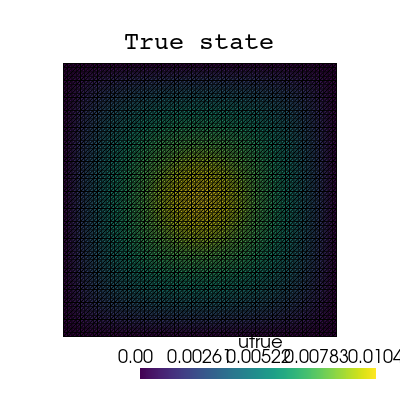

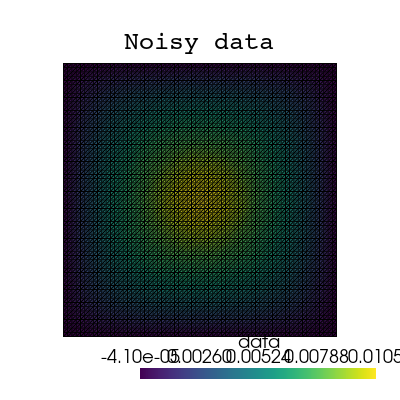

In [10]:
cellsu, typesu, coordsu = dl.plot.create_vtk_mesh(Vhu)
# Create a pyvista mesh and attach the values of u
gridu = pv.UnstructuredGrid(cellsu, typesu, coordsu)

gridu.point_data["utrue"] = utrue.x.array
gridu.set_active_scalars("utrue")

plotteru = pv.Plotter(window_size=window_size)
plotteru.add_mesh(gridu, show_edges=True, show_scalar_bar=True, scalars="utrue")
plotteru.view_xy()
plotteru.add_title('True state', font='courier', color='k', font_size=10)
plotteru.show()

gridu.point_data["data"] = ud.x.array
gridu.set_active_scalars("data")
plotteru = pv.Plotter(window_size=window_size)
plotteru.add_mesh(gridu, show_edges=True, show_scalar_bar=True, scalars="data")
plotteru.view_xy()
plotteru.add_title('Noisy data', font='courier', color='k', font_size=10)
plotteru.show()


### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-u_d)^2\, dx}_{\text misfit} + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text reg}
$$

In [11]:
# Regularization parameter
gamma = 1.e-9

# Define cost function
def cost(u, ud, m, gamma):
    reg_form = dl.fem.form(0.5 * gamma * ufl.inner(ufl.grad(m), ufl.grad(m)) * ufl.dx)
    reg = dl.fem.assemble_scalar(reg_form)
    misfit_form = dl.fem.form(0.5 * (u - ud)**2 * ufl.dx)
    misfit = dl.fem.assemble_scalar(misfit_form)
    return [reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appears in the the state/adjoint equations and gradient evaluations.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear form of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear form of the adjoint equation, repectively;
- `CTvarf`, `gradRvarf` stand for the contributions to the gradient coming from the PDE and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [12]:
# weak form for setting up the state equation
a_state = ufl.exp(m) * ufl.inner(ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_state = f * u_test * ufl.dx

# weak form for setting up the adjoint equations
a_adj = ufl.exp(m) * ufl.inner(ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj = -(u - ud) * p_test * ufl.dx

# weak form for gradient
CTvarf    = ufl.exp(m) * m_test * ufl.inner(ufl.grad(u), ufl.grad(p)) * ufl.dx
gradRvarf = gamma * ufl.inner(ufl.grad(m), ufl.grad(m_test)) * ufl.dx

# Mass matrix in parameter space
Mvarf = m_trial * m_test * ufl.dx
M = dl.fem.petsc.assemble_matrix(dl.fem.form(Mvarf))
M.assemble()

# create an LU solver to be able to apply M^-1
opts = PETSc.Options()
opts["ksp_type"] = "preonly"
opts["pc_type"] = "lu"

# Create PETSc LU solver
Msolver = PETSc.KSP().create(mesh.comm)
Msolver.setFromOptions()

# Set matrix operator
Msolver.setOperators(M)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \mathcal{G}(m_0)(\tilde{m})\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


J(m0) = 1.27e-05
<mhat, grad0> = 1.429e-06


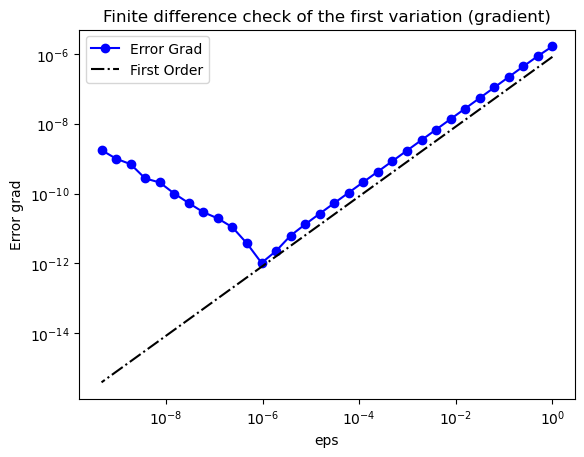

In [14]:
m0 = dl.fem.Function(Vhm)
m0.interpolate(lambda x: np.log(4.0) * np.ones(len(x[0])))

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.vector.zeroEntries()
m.vector.axpy(1.0, m0.vector)

#Solve the fwd problem and evaluate the cost functional
state_problem = dl.fem.petsc.LinearProblem(a_state, L_state, u=u, bcs=bc_state, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
state_problem.solve()

c0, _, _ = cost(u, ud, m, gamma)
print("J(m0) = {0:1.2e}".format(c0))

# Solve the adjoint problem and evaluate the gradient
adj_problem = dl.fem.petsc.LinearProblem(a_adj, L_adj, u=p, bcs=bc_adj, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
adj_problem.solve()

# evaluate the  gradient
grad0 = dl.fem.petsc.assemble_vector(dl.fem.form(CTvarf + gradRvarf))


# Define an arbitrary direction m_hat to perform the check 
mhat = dl.la.create_petsc_vector(Vhm.dofmap.index_map, Vhm.dofmap.index_map_bs)

mhat.setValuesLocal(range(mhat.getLocalSize()), np.random.randn(mhat.getLocalSize()))

mhat_grad0 = grad0.dot(mhat)
print("<mhat, grad0> = {0:1.3e}".format(mhat_grad0))

for i in range(n_eps):
    m.vector.zeroEntries()
    m.vector.axpy(1.0, m0.vector)
    m.vector.axpy(eps[i], mhat)
    state_problem.solve()
    
    cplus, _, _ = cost(u, ud, m, gamma)
    err_grad[i] = abs( (cplus - c0)/eps[i] - mhat_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

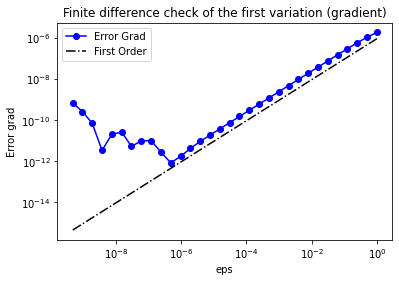

In [7]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, ud, m, gamma)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(CTvarf + gradRvarf)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, ud, m, gamma)
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

In [15]:
m.vector.zeroEntries()
m.vector.axpy(1.0, m0.vector)

# solve state equation
state_problem.solve()

Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 2), Basix element (P, triangle, 2, gll_warped, unset, False)), 3)

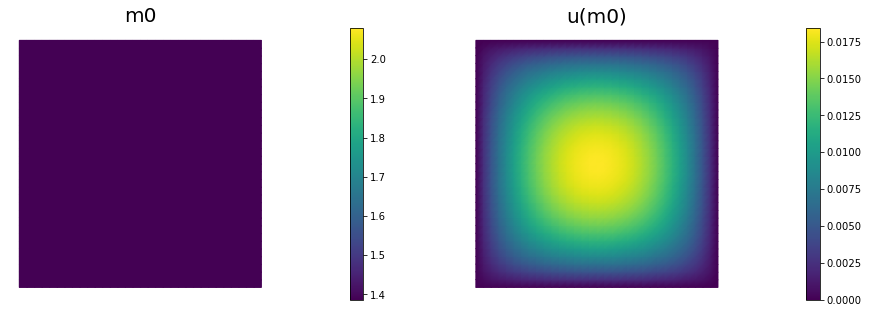

In [8]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equation for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +(\tilde{m}e^m\nabla u, \nabla p).$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} (g,g). $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   1.11658e-05   1.10372e-05   1.28638e-07   6.09224e-05   5.00000e+04     1


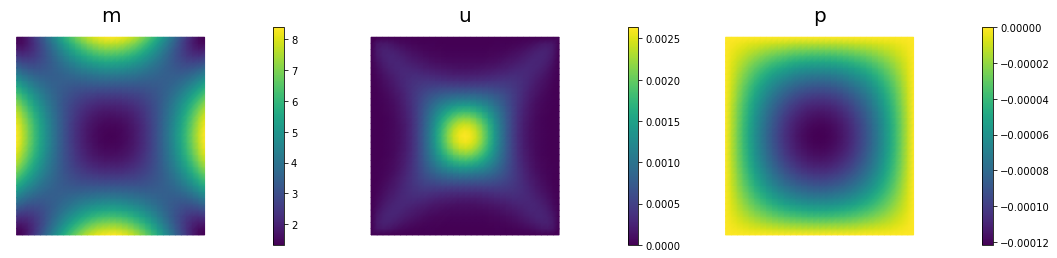

 10   3.07468e-06   2.81411e-06   2.60567e-07   9.96798e-06   2.50000e+04     2
 20   1.68333e-06   1.36733e-06   3.15999e-07   4.79045e-06   2.50000e+04     2
 30   1.08642e-06   7.90406e-07   2.96014e-07   1.08801e-06   1.00000e+05     0
 40   6.99077e-07   4.72703e-07   2.26374e-07   2.65053e-06   2.50000e+04     2
 50   4.33194e-07   2.77234e-07   1.55960e-07   1.89540e-06   2.50000e+04     2


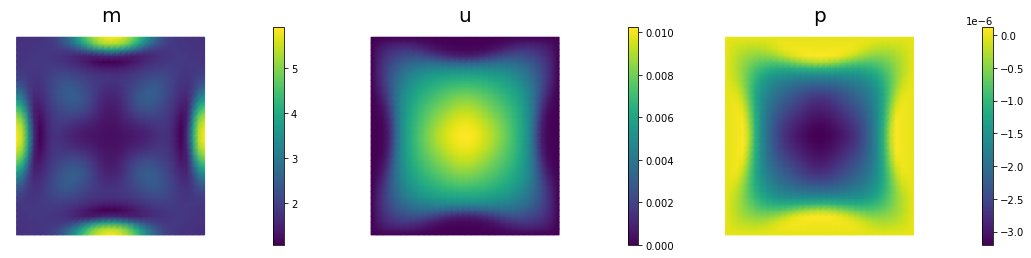

 60   2.08625e-07   1.30743e-07   7.78817e-08   2.16983e-06   2.50000e+04     2
 70   6.76060e-08   4.57894e-08   2.18166e-08   8.24665e-07   5.00000e+04     1
 80   1.48917e-08   1.10392e-08   3.85253e-09   6.15229e-07   5.00000e+04     1
 90   6.29351e-09   4.15392e-09   2.13959e-09   1.56127e-07   5.00000e+04     1
100   5.60737e-09   3.69792e-09   1.90946e-09   4.43594e-08   5.00000e+04     1


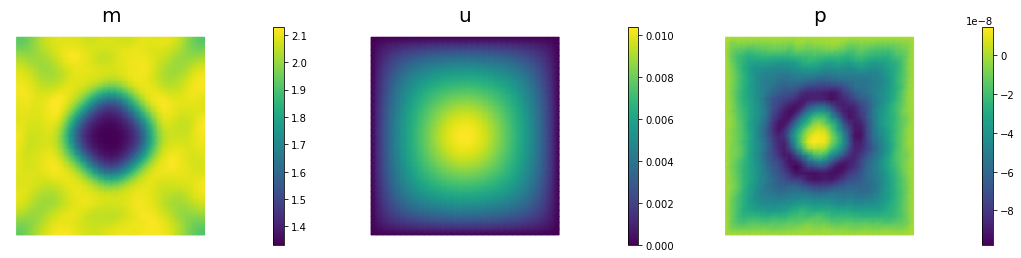

110   5.50313e-09   3.68332e-09   1.81981e-09   1.54409e-08   5.00000e+04     1
120   5.46016e-09   3.69724e-09   1.76293e-09   1.25966e-08   5.00000e+04     1
130   5.43430e-09   3.70647e-09   1.72783e-09   1.07081e-08   5.00000e+04     1
140   5.41730e-09   3.71189e-09   1.70542e-09   9.20452e-09   5.00000e+04     1
150   5.40583e-09   3.71517e-09   1.69066e-09   7.93538e-09   5.00000e+04     1


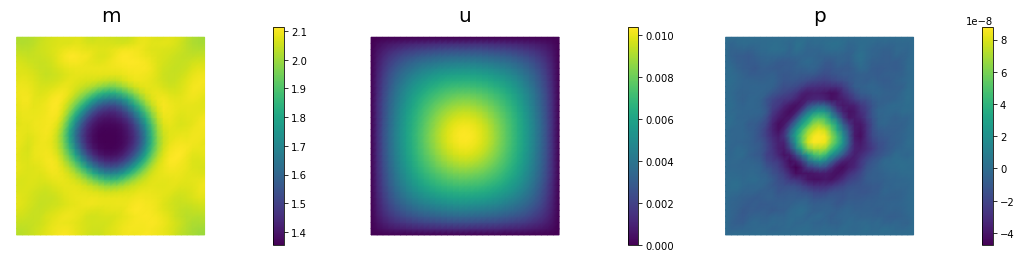

Steepest descent converged in  153   iterations


In [9]:
# define parameters for the optimization
tol = 1e-4
maxiter = 1000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(CTvarf + gradRvarf)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the state/forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset m
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

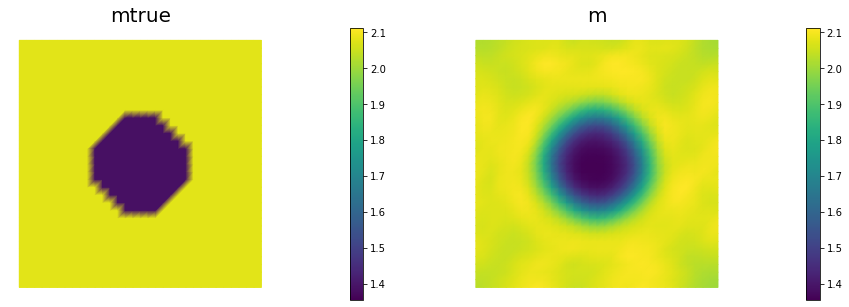

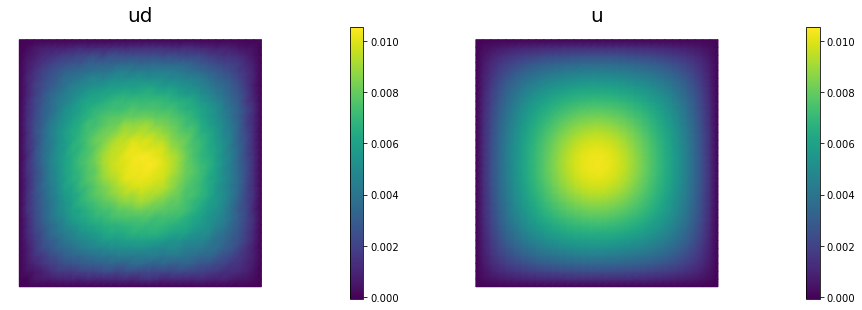

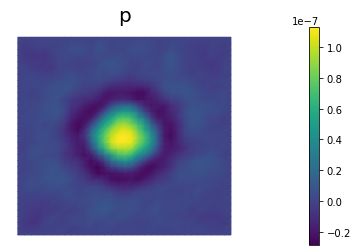

In [10]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([ud,u], ["ud","u"])
plt.show()
nb.plot(p, mytitle="p")
plt.show()

## Hands on

### Question 1

> Report the number of steepest descent iterations for a discretization of the domain with $8 \times 8$, $16 \times 16$, $32 \times 32$, $64 \times 64$ finite elements and give the number of unknowns used to discretize the log diffusivity field $m$ for each of these meshes. Discuss how the number of iterations changes as the inversion parameter mesh is refined, i.e., as the parameter dimension increases. Is the number of steepest descent iterations independent of the parameter dimension?

### Question 2

> Alter the PDE in the above inverse problem, to include an advective term $\mathbf{v}(\mathbf{x})=\begin{pmatrix}
30 \\
0 \\
\end{pmatrix}
$, so that the inverse problem is
$$
\min_{m} J(m):=\frac{1}{2}\int_\Omega (u-u_d)^2\, dx + \frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx,
$$
where $u$ is the solution of
$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) +\mathbf{v}^{\top}\nabla u&= f \text{ in }\Omega,\\
u &= 0 \text{ on }\partial\Omega.
\end{split}
$$
Plot the resulting reconstruction of $m$ for a noise level of 0.01 and for a reasonably chosen regularization parameter $\gamma$.

### Question 3

> Alter the PDE in the above inverse problem, by modifying the boundary conditions, so that the inverse problem is
$$
\min_{m} J(m):=\frac{1}{2}\int_\Omega (u-u_d)^2\, dx + \frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx,
$$
where $u$ is the solution of
$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u)&= f \text{ in }\Omega,\\
u &= 0 \text{ on }\Gamma_{D},\\
-e^{m}\frac{\partial u}{\partial n} &= g \text{ on }\Gamma_{N}.
\end{split}
$$

for $g(x,y)=\sin\left(\pi\,x\right)$ and $\Gamma_{D}=\lbrace (x,y)\in \mathbb{R}^{2} \text{ such that } x=1 \text{ and } 0\leq y\leq 1\rbrace$ and $\Gamma_{N}=\partial\Omega\setminus\Gamma_{D}$.



Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.
All Rights reserved.
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.